In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras import optimizers
from keras import layers
from keras import models
from keras import initializers

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K


base_dir = r'/content/gdrive/My Drive/MVP Datensatz/'
train_dir = r'/content/gdrive/My Drive/MVP Datensatz/Trainingsdatensatz5'


In [84]:
## create base_model

from keras.applications import Xception
base_model = Xception(
  weights = 'imagenet',
  include_top = False,
  input_shape = (299,299,3) # default vaules 
 )

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [85]:
## create train and validation generators

batch_s = 30  # global batch_size

## Train und Vaild Splitting

# Beispiel für mögliche Data Augmentations
train_datagen = ImageDataGenerator(
                          featurewise_center = False,
                          samplewise_center = False,
                          featurewise_std_normalization = False,
                          samplewise_std_normalization = False,
                          rotation_range = 359,
                          width_shift_range = 30.0,
                          height_shift_range = 0.0,
                          brightness_range = None,
                          channel_shift_range = 50.0,
                          horizontal_flip = True, 
                          vertical_flip = True, 
                          rescale = 1./255,
                          validation_split = 0.2, 
                          interpolation_order = 1, 
                          dtype = 'float32'
                          )

rain_datagen = ImageDataGenerator(featurewise_center=False,
                          samplewise_center=False,
                          featurewise_std_normalization=False,
                          samplewise_std_normalization=False,
                          zca_whitening=False,
                          zca_epsilon=1e-06,
                          rotation_range=3,
                          width_shift_range=[-1, 0, +1],
                          height_shift_range=[-1, 0, +1],
                          brightness_range=None, 
                          shear_range=0.1, 
                          zoom_range=0.2,
                          channel_shift_range=0.0, 
                          fill_mode='nearest', 
                          cval=0.0,
                          horizontal_flip=False, 
                          vertical_flip=False, 
                          rescale=1./255, 
                          preprocessing_function=None, 
                          data_format='channels_last', 
                          validation_split=0.2, 
                          interpolation_order=1, 
                          dtype='float32')

valid_datagen = ImageDataGenerator(
                          rescale=1./255,
                          validation_split=0.2
                          )

train_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (299,299),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'training'
                          )

validation_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size = (299,299),
                          batch_size = batch_s,
                          class_mode = 'categorical',
                          subset = 'validation'
                          )           

Found 113 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [93]:
## create model

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation = 'relu'))
model.add(layers.Dense(5,activation = 'sigmoid',kernel_initializer=initializers.RandomNormal(stddev=0.01),bias_initializer=initializers.Zeros()))
# freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_14 (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 204800)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               52429056  
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 1285      
Total params: 73,291,821
Trainable params: 52,430,341
Non-trainable params: 20,861,480
_________________________________________________________________


Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 1.5730 - acc: 0.2035 - val_loss: 1.4607 - val_acc: 0.5200
Epoch 2/20
4/4 [==============================] - 4s 913ms/step - loss: 1.3961 - acc: 0.4336 - val_loss: 1.3223 - val_acc: 0.5200
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 1.2262 - acc: 0.5664 - val_loss: 1.1846 - val_acc: 0.3600
Epoch 4/20
4/4 [==============================] - 5s 1s/step - loss: 1.0924 - acc: 0.6637 - val_loss: 1.1182 - val_acc: 0.6000
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.9698 - acc: 0.6195 - val_loss: 2.2710 - val_acc: 0.6000
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 1.1059 - acc: 0.5752 - val_loss: 0.8696 - val_acc: 0.6000
Epoch 7/20
4/4 [==============================] - 5s 1s/step - loss: 1.0406 - acc: 0.6106 - val_loss: 1.1559 - val_acc: 0.7600
Epoch 8/20
4/4 [==============================] - 5s 1s/step - loss: 0.8755 - acc: 0.6903 - val_loss: 0.8885

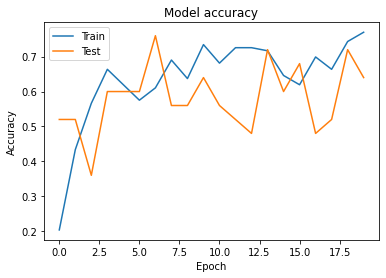

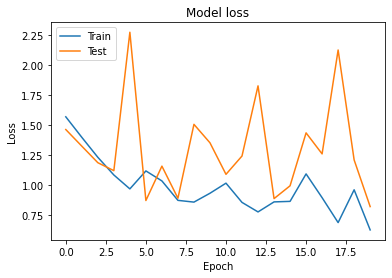

In [94]:
# first: train only the top layers (which were randomly initialized)
opt = optimizers.Adam(learning_rate=0.0009)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

epochs = 20
history = model.fit_generator(
                    train_generator,
                    epochs = epochs,
                    validation_data = validation_generator
                    )

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save("/content/gdrive/My Drive/Keras Models/Xception_5-1.h5")


In [99]:
## Validierung auf Abfragebildern
testbild = base_dir + 'Testbilder/P1040697.JPG'
testbild = image.load_img(testbild, target_size=(299,299))
testbild = image.img_to_array(testbild)
testbild = np.expand_dims(testbild, axis=0)
predictions = model.predict(testbild)

predictions

array([[0., 0., 0., 0., 0.]], dtype=float32)

In [101]:
# image folder
folder_path = base_dir + 'Testbilder/'
# path to model
model_path = '/path/to/saved/model.h5'
# dimensions of images
img_width, img_height = 299, 299


# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images)
print(classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 3 0 0 0 0 0 0 3 3 3 0 3 0 3 0 0 3]


In [0]:
def Vorhersage(Artikelfoto, Speicherort_KI_Modell, Name_KI_Modell):

    model = models.load_model(Speicherort_KI_Modell + Name_KI_Modell)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    Artikelfoto = image.load_img(Artikelfoto, target_size=(img_width, img_height))
    Artikelfoto = image.img_to_array(Artikelfoto)
    Artikelfoto = np.expand_dims(Artikelfoto, axis=0)
    prediction = model.predict_proba(Artikelfoto)

    return {
        'category': np.argmax(prediction),
        'probs': {c: round(float(prediction[i]),5) for (i,c) in enumerate(prediction)}
    }


In [106]:
Vorhersage(base_dir + 'Testbilder/P1040695.JPG', '/content/gdrive/My Drive/Keras Models', '/Xception_5-1.h5')

TypeError: ignored

In [0]:
## wird momentan nicht verwendet

## extract features from data set

batch_size = batch_s
def extract_features(directory, sample_count, gen):
  features = np.zeros(shape=(sample_count, 2048)) 
  labels = np.zeros(shape=(sample_count, 5))
  generator = gen
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = base_model.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 113, train_generator)
validation_features, validation_labels = extract_features(train_dir, 25, validation_generator)
